#  네이버 영화리뷰 감성분석

## 필요한 라이브러리를 불러오고 데이터 준비 및 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os

# 데이터를 불러옴
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터 로더 구성

데이터의 중복치 제거

NaN 결측치 제거

한국어 토크나이저로 토큰화

불용어(Stopwords) 제거

사전word_to_index 구성

텍스트 스트링을 사전 인덱스 스트링으로 변환

X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# load_data 함수
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if word not in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if word not in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '<UNUSED>', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '재밌', 35: '어', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '에서', 42: '기', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '

#### 사용할 함수를 만들어 줍니다.

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

#### X_train과 X_test의 개수를 확인합니다.

In [5]:
print(f"훈련 샘플 개수 : {len(X_train)}, 테스트 개수 : {len(X_test)}")

훈련 샘플 개수 : 146182, 테스트 개수 : 49157


In [6]:
# decoding
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


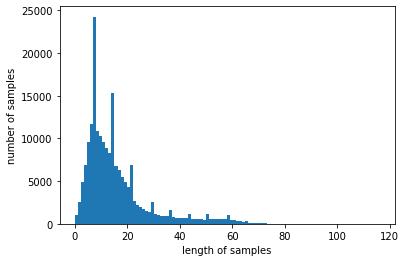

In [7]:
# 텍스트데이터 문장길이 리스트 생성
total_data_text = list(X_train) + list(X_test)

# 문장길이의 평균값, 최대값, 표준편차 계산
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 가정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

plt.clf()
plt.hist([len(s) for s in total_data_text], bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.show()

In [8]:
# padding
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre','post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre', 'post'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


#### 훈련용 데이터셋 중 25000건을 분리하여 validation set으로 사용

In [9]:
# validation set 10000건 분리
X_val = X_train[:25000]   
y_val = y_train[:25000]

# validation set을 제외한 나머지
partial_X_train = X_train[25000:]  
partial_y_train = y_train[25000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)

(121182, 41)
(121182,)
(25000, 41)


### RNN 모델 설계

In [10]:
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import regularizers

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 설계

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 182,946
Trainable params: 182,946
Non-trainable params: 0
__________________________________________________

#### 모델을 학습시킵니다.

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
474/474 [==============================] - 23s 7ms/step - loss: 0.5186 - accuracy: 0.7667 - val_loss: 0.3785 - val_accuracy: 0.8462
Epoch 2/5
474/474 [==============================] - 3s 6ms/step - loss: 0.3416 - accuracy: 0.8607 - val_loss: 0.3490 - val_accuracy: 0.8522
Epoch 3/5
474/474 [==============================] - 3s 6ms/step - loss: 0.3015 - accuracy: 0.8764 - val_loss: 0.3385 - val_accuracy: 0.8577
Epoch 4/5
474/474 [==============================] - 3s 6ms/step - loss: 0.2731 - accuracy: 0.8893 - val_loss: 0.3317 - val_accuracy: 0.8592
Epoch 5/5
474/474 [==============================] - 3s 6ms/step - loss: 0.2506 - accuracy: 0.8998 - val_loss: 0.3348 - val_accuracy: 0.8602


#### 학습이 완료된 모델을 test set으로 평가합니다.

In [12]:
# 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3422 - accuracy: 0.8553
[0.34216558933258057, 0.8553410768508911]


모델을 fitting하는 과정에서 train loss, train accuracy, validation loss, validation accuracy 등이 매 epoch 진행될 때 마다 history 변수에 저장됩니다.

In [13]:
# 모델의 fitting 과정 중 정보를 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


#### training loss & validation loss를 그려봅니다.

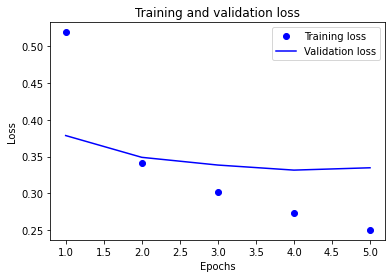

In [14]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### training accuracy & validation accuracy를 그려봅니다.

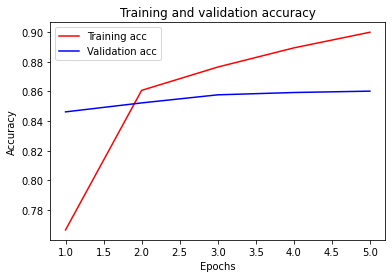

In [15]:
# Training and Validation accuracy
#plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Word2Vec
#### Embedding Layer 확인해봅니다.

In [16]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


#### 학습한 Embedding 파라미터를 파일에 써서 저장합니다.

In [17]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

### gensim 라이브러리를 불러옵니다.
#### 임베딩 파라미터를 읽어서 word vector로 활용합니다.

In [18]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['강아지']
vector

array([ 0.05562501, -0.03567958,  0.04084449, -0.02206706, -0.01873682,
        0.03181148, -0.02190064, -0.00027283,  0.05049843,  0.02451248,
        0.02698615, -0.0487751 ,  0.03001909,  0.03281145,  0.03600714,
       -0.00423105], dtype=float32)

In [19]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)


In [20]:
# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

### RNN 모델 설계

In [21]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
_________________________________________________________________
dense_6 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 182,946
Trainable params: 182,946
Non-trainable params: 0
________________________________________________

#### 모델을 학습시킵니다.

In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
474/474 [==============================] - 5s 7ms/step - loss: 0.4999 - accuracy: 0.8081 - val_loss: 0.3843 - val_accuracy: 0.8514
Epoch 2/5
474/474 [==============================] - 3s 6ms/step - loss: 0.3048 - accuracy: 0.8849 - val_loss: 0.3446 - val_accuracy: 0.8571
Epoch 3/5
474/474 [==============================] - 3s 6ms/step - loss: 0.2539 - accuracy: 0.9023 - val_loss: 0.3456 - val_accuracy: 0.8574
Epoch 4/5
474/474 [==============================] - 3s 6ms/step - loss: 0.2293 - accuracy: 0.9126 - val_loss: 0.3621 - val_accuracy: 0.8551
Epoch 5/5
474/474 [==============================] - 3s 6ms/step - loss: 0.2130 - accuracy: 0.9202 - val_loss: 0.3722 - val_accuracy: 0.8549


#### 모델을 평가해봅니다.

In [24]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3762 - accuracy: 0.8520
[0.3762110471725464, 0.8520048260688782]


In [25]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [26]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

#### training loss & validation loss 를 그려서 확인합니다.

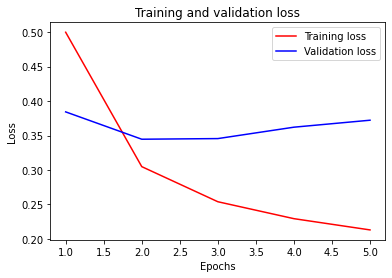

In [27]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### training accuracy & validation accuracy 를 그려서 확인해봅니다.

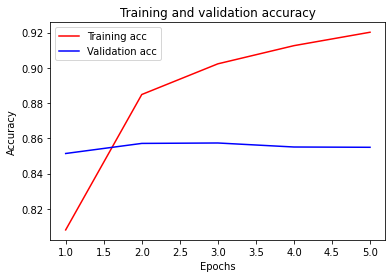

In [28]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고

## 생각한 것보다 점점 난이도가 올라간다.

자연어 처리는 처음입니다.

어렵네요.

여러개의 모델을 쓰고 싶기는 한데 생각보다 따라가려니 시간이 부족하네요.

더 열심히 해야겠다는 생각이 늘 드네요.

파이팅합시다.

간신히 수치 바꾸면서 정확도 85% 턱걸이로 맞췄습니다.

생각보다 정확도 높은 모델을 설계하는 것이 어렵다는 것도 다시금 깨달았네요..

Fighting...!